In [1]:
using CombinatorialSpaces, CairoMakie, DifferentialEquations
using MeshIO

function dual(s::EmbeddedDeltaSet2D{O, P}) where {O, P}
  sd = EmbeddedDeltaDualComplex2D{O, eltype(P), P}(s)
  subdivide_duals!(sd, Barycenter())
  sd
end

dual (generic function with 1 method)

## Define and plot mesh and boundary conditions

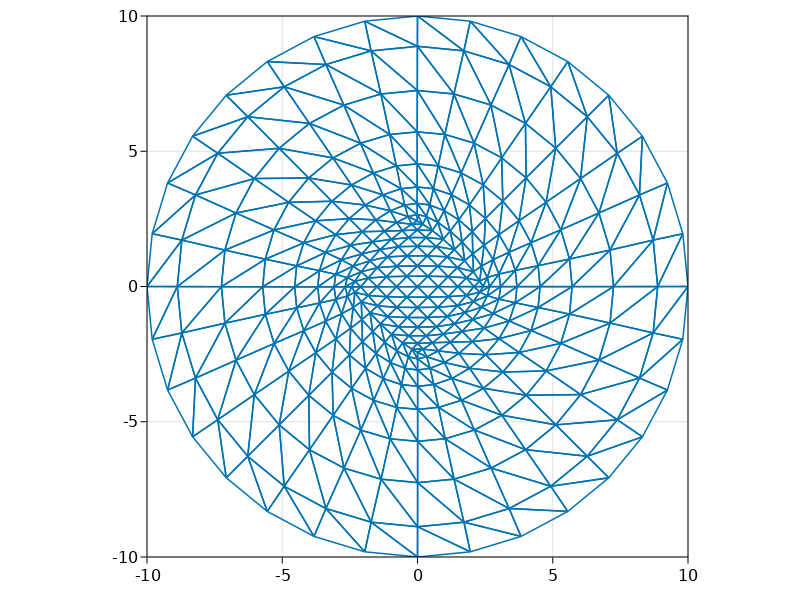

In [2]:
s = EmbeddedDeltaSet2D("meshes/disk_2_0.stl")
sd = dual(s);

# boundary conditions
boundary_e = findall(x -> x != 0, boundary(Val{2},s) * fill(1,ntriangles(s)))
boundary_v = unique(vcat(s[boundary_e,:src],s[boundary_e,:tgt]))

# plot
fig, ax, ob = wireframe(s)
ax.aspect = AxisAspect(1)
xlims!(ax, (-10,10))
ylims!(ax, (-10,10))
fig

## Add the physics

In [3]:
y = [(100 - (p[1]^2 + p[2]^2)) * 0.01 for p in s[:point]];
v = [0.0 for p in s[:point]]
y_range = 1:length(y)
v_range = (1:length(v)) .+ length(y)

lapl = ∇²(Val{0}, sd) # initialize the laplacian operator

u0 = vcat(y, v) # initial condition for displacement

vf(du, u, p, t) = begin
    du[v_range] .= ( p[1]) .* (lapl * u[y_range]) # wave equation
    du[y_range] .= u[v_range] # updates velocity
    du[y_range[boundary_v]] .= 0
    du[v_range[boundary_v]] .= 0
end

vf (generic function with 1 method)

## Run the simulation(s)

In [4]:
tspan = (0.0,100.0)
prob = ODEProblem(vf, u0, tspan, [100])
sol = solve(prob);

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\mgatlin3\.julia\packages\SciMLBase\UIp7W\src\integrator_interface.jl:351


## Plot results

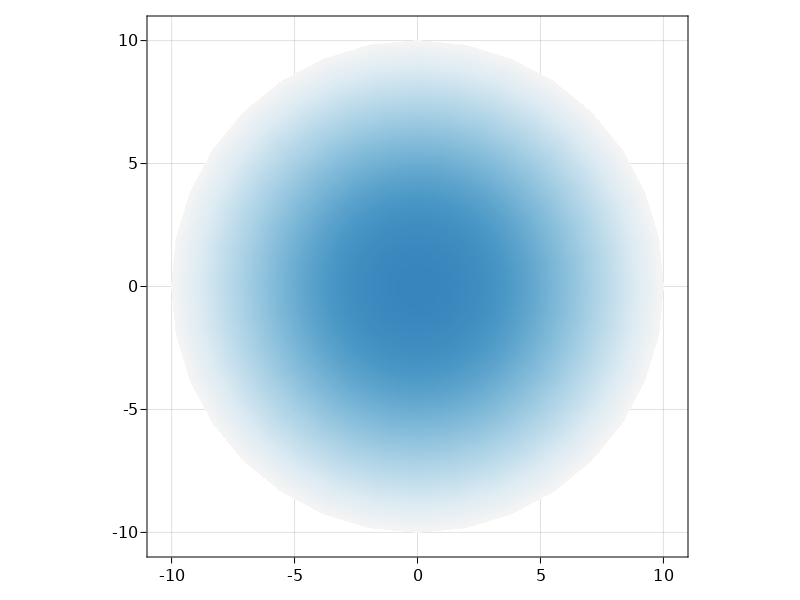

In [6]:
inner_mask = findall((p)-> (p[1]^2 + p[2]^2 < 25), s[:point])
val = lapl*sol(0)[y_range]
color = fill(minimum(val[inner_mask]), nv(s))
color[inner_mask] .= val[inner_mask]
fig, ax, ob = mesh(s, color=sol(0)[y_range], colorrange=(-1.5,1.5), colormap=:RdBu)
ax.aspect = AxisAspect(1)
fig

## Record results (2D)

In [ ]:
i_range = range(0,12.5, length=75)
framerate = 15
record(fig, "drum.gif", i_range; framerate = framerate) do i
  ob.color = sol(i)
end

## Record results (3D)

In [5]:
tn = Node(0.0)
s2 = deepcopy(s)
f(t) = begin
    s2[:point] .= [eltype(s2[:point])(p[1],p[2],sol(t)[y_range[i]]) for (i,p) in enumerate(s2[:point])]
    s2
end
limits = FRect3D(Vec3f0(-13.0, -13.0, -13.0), Vec3f0(13.0,13.0,13.0))
fig, ax, ob = wireframe(lift(t->f(t), tn); limits=limits)
i_range = range(0,12.5, length=150)
framerate = 30
record(fig, "drum_3D.gif", i_range; framerate = framerate) do i
  tn[] = i
end

"drum_3D.gif"